# Machine Learning Security Project - Project 3
Re-evaluate 5 RobustBench models with another attack algorithm (e.g. FMN) and identify samples for which one attack works and the other doesn't. Explain the results - i.e., provide some motivations on why one of the attacks did not work properly, while the other did.

## Libraries

In [1]:
try:
    import secml
except ImportError:
    %pip install git+https://github.com/pralab/secml

try:
    import foolbox as fb
except ImportError:
    %pip install foolbox

try:
    import robustbench
except ImportError:
    %pip install git+https://github.com/RobustBench/robustbench.git

import os
import gc
import torch
import numpy as np

import matplotlib.pyplot as plt

from secml.array import CArray
from secml.ml import CClassifierPyTorch
from secml.ml.peval.metrics import CMetricAccuracy
from secml.adv.attacks.evasion import CAttackEvasionFoolbox
from secml.data.loader import CDataLoaderCIFAR10
from secml.ml.features.normalization import CNormalizerMinMax
from secml.figure import CFigure
from secml.explanation import \
    CExplainerGradient, CExplainerGradientInput, CExplainerIntegratedGradients
from secml.utils import fm
from secml import settings
from secml.ml.classifiers.loss import CSoftmax

from robustbench.utils import load_model

from torch import nn

### Mount Google Drive

In [2]:
#from google.colab import drive

#drive.mount('/content/drive')
#os.chdir("/content/drive/MyDrive/University/Master Degree/MLSec")

os.chdir("secml-data/models")

output_dir = fm.join(settings.SECML_MODELS_DIR, 'robustbench')

## Global Variables
Contains definition of global variables

In [3]:
input_shape    = (3, 32, 32)
model_names    = [
    "Wong2020Fast",
    "Engstrom2019Robustness",
    "Andriushchenko2020Understanding",
    "Cui2023Decoupled_WRN-28-10",
    "Chen2020Adversarial"
]
n_samples      = 64
dataset_labels = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

## Loading models

Loads five models from robustbench. We have chosen the following models:
*   1 - Wong2020Fast
*   2 - Engstrom2019Robustness
*   3 - Andriushchenko2020Understanding
*   4 - Cui2023Decoupled_WRN-28-10
*   5 - Chen2020Adversarial

In [4]:
def load_model(model_name):
    """
    Load a single model from Robustbench and
    wrap it into a CClassifier
    """
    model = robustbench.utils.load_model(
        model_name=model_name,
        dataset='cifar10',
        threat_model='Linf',
        model_dir=output_dir
    )

    clf  = CClassifierPyTorch(
        model,
        input_shape=input_shape,
        pretrained=True,
        pretrained_classes=CArray(list(range(10))),
        preprocess=None
    )

    return clf

# Main

models = [
    load_model(
        model_names[idx]
    ) for idx in range(5)
]

## Loading  CIFAR-10

Loads 64 samples from CIFAR-10 dataset with shape (3, 32, 32)

In [5]:
tr, ts      = CDataLoaderCIFAR10().load()
normalizer  = CNormalizerMinMax().fit(tr.X)

ts          = ts[:n_samples, :]

# Normalize test samples
ts.X = normalizer.transform(ts.X)

## Fast-Minimum-Norm (FMN) attack

Computes the accuracy of the models, just to confirm that it is working properly.

In [59]:
metric        = CMetricAccuracy()
models_preds  = [clf.predict(ts.X) for clf in models]
accuracies    = [metric.performance_score(y_true=ts.Y, y_pred=y_pred) for y_pred in models_preds]

for idx in range(5):
    print(f"Model idx: {idx+1} - Clean model accuracy: {(accuracies[idx] * 100):.2f} %")

Model idx: 1 - Clean model accuracy: 84.38 %
Model idx: 2 - Clean model accuracy: 89.06 %
Model idx: 3 - Clean model accuracy: 78.12 %
Model idx: 4 - Clean model accuracy: 93.75 %
Model idx: 5 - Clean model accuracy: 81.25 %


Runs the FMN attack on each model

In [6]:
def attack_models(samples, labels):
    init_params = dict(steps        = 500,
                       max_stepsize = 1.0,
                       gamma        = 0.05)
    attack_data = dict()

    # Run the attack on each model
    for idx, model in enumerate(models):
        print(f"Starting attack on model {idx+1}")

        # Untargeted attack
        attack = CAttackEvasionFoolbox(
                model,
                y_target=None,
                epsilons=8/255,
                fb_attack_class=fb.attacks.LInfFMNAttack,
                **init_params)

        y_pred, _, adv_ds, _ = attack.run(samples, labels)

        attack_data[idx] = {
            'x_seq'        : attack.x_seq,
            'y_pred_adv'   : y_pred,
            'adv_ds'       : adv_ds
        }

        print(f"Attack complete on model {idx+1}")

    return attack_data

attack_data = attack_models(ts.X, ts.Y)

Saves attack data on the disk

In [61]:
import pickle
# from google.colab import files

# with open('attack_data.bin', 'wb') as file:
#     pickle.dump(attack_data, file)

# files.download('attack_data.bin')

with open('attack_data.bin', 'rb') as file:
    attack_data = pickle.load(file)

Computes the new accuracy for each model using the generated adversarial examples in order to evaluate their robustness.

In [62]:
for idx, model in enumerate(models):
    accuracy = metric.performance_score(
        y_true=ts.Y,
        y_pred=attack_data[idx]['y_pred_adv']
    )

    print(f"Model idx: {idx+1} - Model accuracy under attack: {(accuracy * 100):.2f} %")

Model idx: 1 - Model accuracy under attack: 42.19 %
Model idx: 2 - Model accuracy under attack: 46.88 %
Model idx: 3 - Model accuracy under attack: 43.75 %
Model idx: 4 - Model accuracy under attack: 67.19 %
Model idx: 5 - Model accuracy under attack: 45.31 %


## Explainability

Computes explainations for the adversarial images

In [70]:
model_id        = 4
samples         = [0,1,2,3,4,5] # Ipotesi
attributions    = []
explainer       = CExplainerIntegratedGradients(models[model_id])

# Run explainability...
for ydx, idx in enumerate(samples):
    attributions.append(dict())

    # Sample
    x = attack_data[model_id]['adv_ds'].X[idx, :]

    # Compute explanations (attributions) wrt each class
    print(f"Computing explanations using '{expl_name} for {idx+1}'...")

    # Empty array where to collect attributions values
    attr = CArray.empty(shape=(ts.num_classes, x.size))

    # Loop over classes
    for c in ts.classes:
        # Compute the explanation
        attr_c = explainer.explain(x, y=c)
        attr[c, :] = attr_c

    attributions[ydx] = attr

Computing explanations using 'integrated gradients for 1'...
Computing explanations using 'integrated gradients for 2'...
Computing explanations using 'integrated gradients for 3'...
Computing explanations using 'integrated gradients for 4'...
Computing explanations using 'integrated gradients for 5'...
Computing explanations using 'integrated gradients for 6'...


Shows explainations results

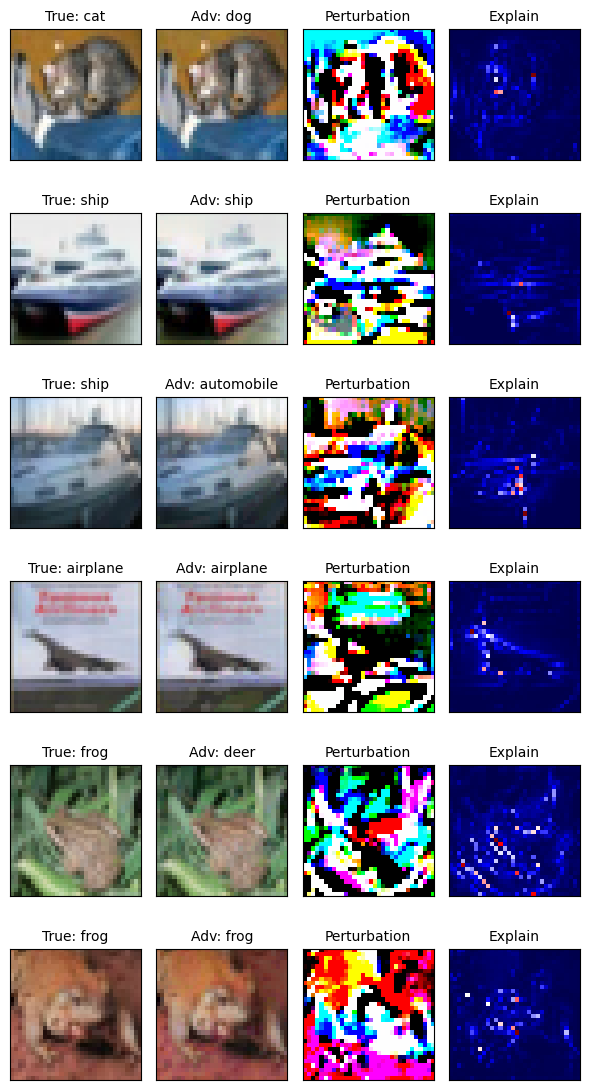

In [71]:
def convert_image(image):
    return image.tondarray().reshape(input_shape).transpose(1, 2, 0)

def show_image(fig, idx, img, img_adv, expl, label, pred):
    diff_img = img_adv - img
    diff_img -= diff_img.min()
    diff_img /= diff_img.max()

    # True sample
    fig.subplot(10, 4, idx*4+1)
    fig.sp.imshow(convert_image(img))
    fig.sp.title(f"True: {label}")
    fig.sp.xticks([])
    fig.sp.yticks([])

    # Adv sample
    fig.subplot(10, 4, idx*4+2)
    fig.sp.imshow(convert_image(img_adv))
    fig.sp.title(f'Adv: {pred}')
    fig.sp.xticks([])
    fig.sp.yticks([])

    # Perturbation
    fig.subplot(10, 4, idx*4+3)
    fig.sp.imshow(convert_image(diff_img))
    fig.sp.title('Perturbation')
    fig.sp.xticks([])
    fig.sp.yticks([])

    # Explaination
    # Calculate the maximum error for each pixel
    expl = convert_image(expl)
    r = np.fabs(expl[:, :, 0])
    g = np.fabs(expl[:, :, 1])
    b = np.fabs(expl[:, :, 2])
    expl = np.maximum(np.maximum(r, g), b)

    fig.subplot(10, 4, idx*4+4)
    fig.sp.imshow(expl, cmap='seismic')
    fig.sp.title('Explain')
    fig.sp.xticks([])
    fig.sp.yticks([])

# Main

adv_ds = attack_data[model_id]['adv_ds']
y_adv  = attack_data[model_id]['y_pred_adv']

fig = CFigure(height=20, width=6, fontsize=10)

for ydx, idx in enumerate(samples):
    img     = ts.X[idx, :]
    img_adv = adv_ds.X[idx, :]
    expl    = attributions[ydx][y_adv[idx].item(), :]

    show_image(
        fig,
        ydx,
        img,
        img_adv,
        expl,
        dataset_labels[ts.Y[idx].item()],
        dataset_labels[y_adv[idx].item()]
    )

fig.tight_layout(rect=[0, 0.003, 1, 0.94])
fig.savefig("explainability.jpg")
fig.show()

To check if the attack has properly converged to a good local minimum, we plot how the predicted confidence values of the target (solid line) and true class (dotted line) change across the attack iterations.

In [72]:
sample_id = 2
sample    = ts.X[sample_id, :]
label     = ts.Y[sample_id]

attack_data = attack_models(sample, label)

Starting attack on model 1
Attack complete on model 1
Starting attack on model 2
Attack complete on model 2
Starting attack on model 3
Attack complete on model 3
Starting attack on model 4
Attack complete on model 4
Starting attack on model 5
Attack complete on model 5


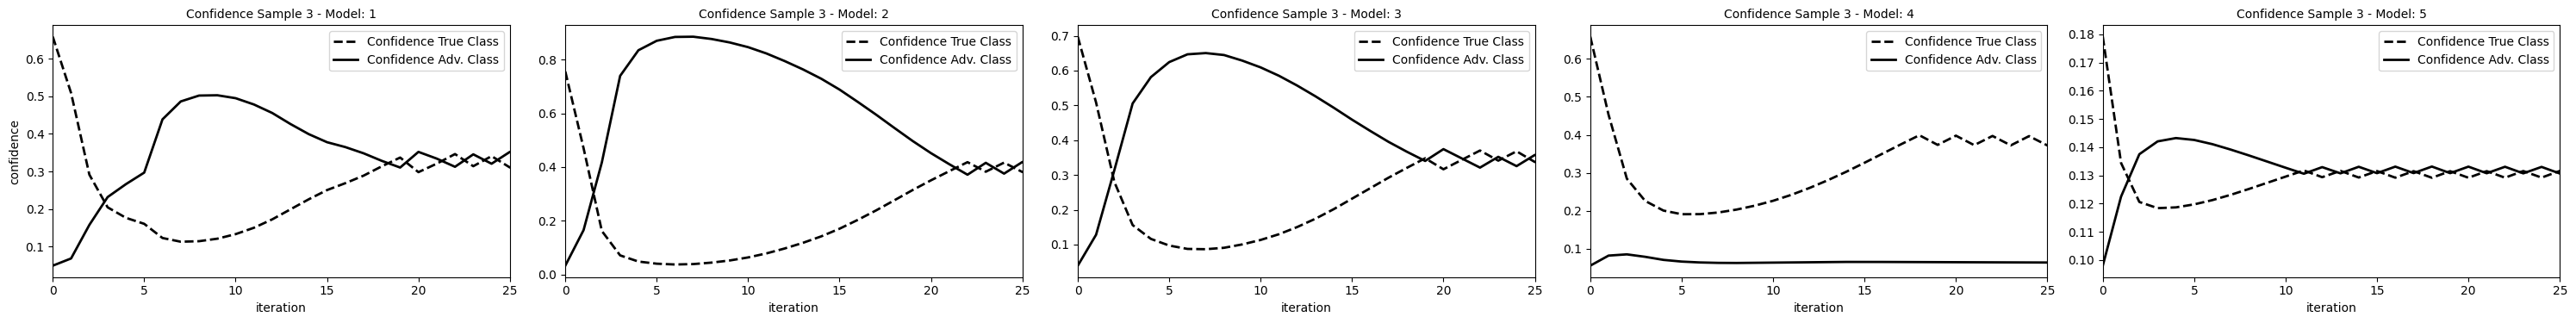

In [74]:
fig = CFigure(width=30, height=4, fontsize=10, linewidth=2)

for model_id in range(5):
    n_iter = attack_data[model_id]['x_seq'].shape[0]
    itrs = CArray.arange(n_iter)

    # Classify all the points in the attack path
    scores = models[model_id].predict(
        attack_data[model_id]['x_seq'],
        return_decision_function=True
    )[1]

    # Apply the softmax to the score to have value in [0,1]
    scores = CSoftmax().softmax(scores)

    fig.subplot(1, 5, model_id+1)

    if model_id == 0:
        fig.sp.ylabel('confidence')

    fig.sp.xlabel('iteration')

    fig.sp.plot(itrs, scores[:, label], linestyle='--', c='black')
    fig.sp.plot(itrs, scores[:, attack_data[0]['y_pred_adv'][0]], c='black')

    fig.sp.xlim(top=25, bottom=0)

    fig.sp.title(f"Confidence Sample {sample_id+1} - Model: {model_id+1}")
    fig.sp.legend(['Confidence True Class', 'Confidence Adv. Class'])

fig.tight_layout()
fig.show()